In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
position_file_location = 'rank_0_positions.txt'

with open(position_file_location, 'r') as file:
    
    file.readline()  # Skip the line with the number of nodes
    file.readline()  # Skip the min/max lines
    file.readline()  # Skip the min/max lines
    file.readline()  # Skip the empty line
        
    positions = []
    labels = []
    types = []
        
    for line in file:
        # Skip lines that start with "Maximum" or "Minimum" or any comment lines
        if line.startswith("Maximum") or line.startswith("Minimum") or line.startswith("#"):
            continue
                
        # Split the line by spaces
        parts = line.split()
            
        # Ensure the line has the correct number of parts
        if len(parts) >= 6:
            x, y, z = map(float, parts[1:4])
            area = parts[4]
            neuron_type = parts[5]
                    
            positions.append([x, y, z])
            labels.append(area)
            types.append(neuron_type)
    
    positions = np.array(positions)

/var/folders/1s/s3n0mk7s45n_8bvs1l6047sc0000gp/T/ipykernel_20845/2378537038.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_areas))


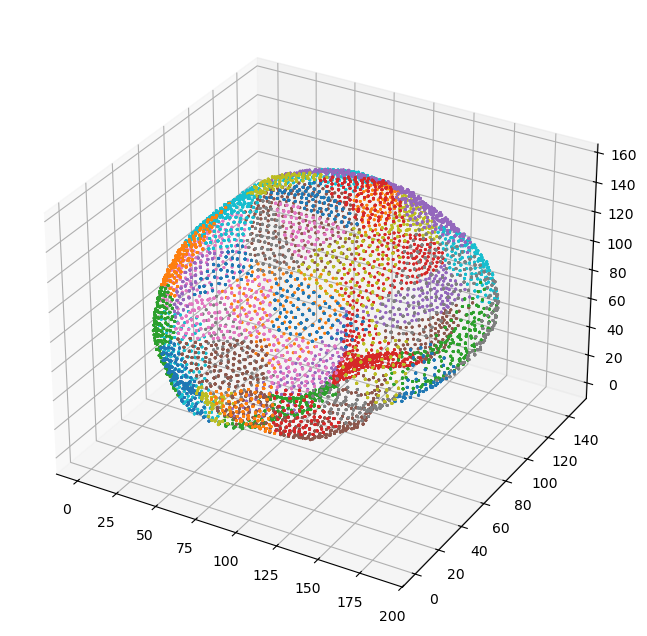

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_areas = list(set(labels))
colors = plt.cm.get_cmap('tab10', len(unique_areas))
area_color_map = {area: colors(i) for i, area in enumerate(unique_areas)}

node_colors = [area_color_map[area] for area in labels]

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=node_colors, s=1)

plt.show()